# MLR

# Importing Libraries

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

parts_analysis = ["#046d8b", "#0190ba", "#004b60", "#e0576a", "#b42a3d", "#9a303e"]

# CPU

## Cleaning the Data

In [149]:
df = pd.read_csv('PC_Part_Picker_Datasets\CPU_Data.csv')
#drop GHz from Performance Core Clock and Boost Clock
df['Performance Core Clock'] = df['Performance Core Clock'].str.replace(' GHz', '')
df['Boost Clock'] = df['Boost Clock'].str.replace(' GHz', '')
#change Performance Core Clock and Boost Clock to float
df['Performance Core Clock'] = df['Performance Core Clock'].astype(float)
df['Boost Clock'] = df['Boost Clock'].astype(float)
#remove the spaces from the column names
df.columns = df.columns.str.replace(' ', '_')

## Establishing Response and Feature Variables

In [150]:
x = df[[ 'Core_Count','Performance_Core_Clock' ]]
y = df['Price']

## Running the MLR Model

In [151]:
regr = linear_model.LinearRegression()
regr.fit(x, y)

#print out MLR summary
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print_model = model.summary()
print(print_model)

#check the accuracy of the model
accuracy = regr.score(x, y)
print('Accuracy: ', accuracy)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     37.36
Date:                Fri, 19 Apr 2024   Prob (F-statistic):           1.40e-14
Time:                        15:04:01   Log-Likelihood:                -1423.1
No. Observations:                 210   AIC:                             2852.
Df Residuals:                     207   BIC:                             2862.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -197

# R^2 is low and indicates not a good model fit, outliers maybe at play here

In [152]:
#Find any CPU with outliers in Price on the high end
df['Price_z'] = (df['Price'] - df['Price'].mean()) / df['Price'].std()
df['Price_z'] = np.abs(df['Price_z'])
outliers = df[df['Price_z'] > 2]
print(outliers)

#Drop the outliers high end
df = df[df['Price_z'] < 2]
df = df.drop(columns=['Price_z'])

     Brand             Model  Core_Count  Performance_Core_Clock  Boost_Clock  \
115    AMD   Ryzen 9 3950X            16                     3.5          4.7   
124  Intel  Core i9-9900KS             8                     4.0          5.0   
157  Intel   Core i9-9900K             8                     3.6          5.0   
185  Intel  Core i9-7980XE            18                     2.6          4.4   
197  Intel   Core i9-7900X            10                     3.3          4.5   
202  Intel  Core i9-7980XE            18                     2.6          4.4   

       TDP     Integrated_Graphics Sockets_Supported  Rating  Rating_Count  \
115  105 W                     NaN               Yes       0             0   
124  127 W  Intel UHD Graphics 630               Yes       5             7   
157   95 W  Intel UHD Graphics 630               Yes       5             2   
185  165 W                     NaN               Yes       4             1   
197  140 W                     NaN        

# Rerunning the model after removing the outliers in High Price

In [153]:
x = df[[ 'Core_Count','Performance_Core_Clock' ]]
y = df['Price']

regr = linear_model.LinearRegression()
regr.fit(x, y)

#print out MLR summary
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print_model = model.summary()
print(print_model)

#check the accuracy of the model
accuracy = regr.score(x, y)
print('Accuracy: ', accuracy)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     106.7
Date:                Fri, 19 Apr 2024   Prob (F-statistic):           2.62e-32
Time:                        15:04:01   Log-Likelihood:                -1222.2
No. Observations:                 204   AIC:                             2450.
Df Residuals:                     201   BIC:                             2460.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -95

# Finding the CPU's in each Category that has the lowest Residual indicating high performance to cost ratio

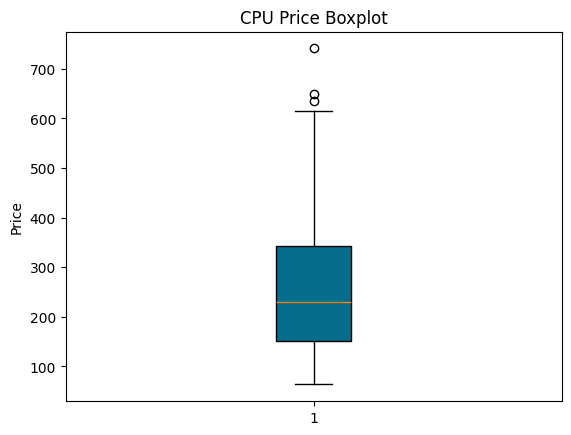

count    204.000000
mean     258.923431
std      139.294443
min       63.500000
25%      151.165000
50%      229.475000
75%      342.490000
max      741.000000
Name: Price, dtype: float64


In [154]:
#Generate a boxplot for the CPU Price column
plt.boxplot(df['Price'], patch_artist=True, boxprops=dict(facecolor=parts_analysis[0]))
plt.title('CPU Price Boxplot')
plt.ylabel('Price')
plt.show()

# I want to see the prices at each tick on the boxplot
print(df['Price'].describe())

In [155]:
#add the residuals to the dataframe
df['residuals'] = y - regr.predict(x)
#move the residuals to the first column
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

## Low End CPU Selection

In [156]:
#create a new dataframe called Low Price that contains all the CPUs with a price less than 153.5
Low_Price = df[df['Price'] < 151.17]
#sort the dataframe by residuals in ascending order
Low_Price = Low_Price.sort_values(by='residuals', ascending=True)
Low_Price.head()
#set the best_low_cpu to the first row of the Low_Price dataframe
best_low_cpu = Low_Price.iloc[0]
best_low_cpu

residuals                    -141.575453
Brand                                AMD
Model                     Ryzen 5 4500  
Core_Count                             6
Performance_Core_Clock               3.6
Boost_Clock                          4.1
TDP                                 65 W
Integrated_Graphics                  NaN
Sockets_Supported                    Yes
Rating                                 5
Rating_Count                          11
Price                               78.5
Release_Year                      2020.0
Socket_Type                          AM4
Name: 29, dtype: object

## Medium End CPU Selection

In [157]:
#create a new dataframe called Medium Price that contains all the CPUs with a price more than 153.5 and less than 234.995
Medium_Price = df[(df['Price'] > 153.5) & (df['Price'] < 229.48)]
#sort the dataframe by residuals in ascending order
Medium_Price = Medium_Price.sort_values(by='residuals', ascending=True)
Medium_Price.head()
#set the best_low_cpu to the first row of the Low_Price dataframe
best_medium_cpu = Medium_Price.iloc[0]
best_medium_cpu

residuals                       -148.138217
Brand                                 Intel
Model                     Core i5-12600KF  
Core_Count                               10
Performance_Core_Clock                  3.7
Boost_Clock                             4.9
TDP                                   125 W
Integrated_Graphics                     NaN
Sockets_Supported                       Yes
Rating                                    5
Rating_Count                             46
Price                                160.99
Release_Year                         2021.0
Socket_Type                        LGA 1200
Name: 18, dtype: object

## High End CPU Selection

In [158]:
#create a new dataframe called High Price that contains all the CPUs with a price more than 234.995 and less than 360.5525
High_Price = df[(df['Price'] > 234.995) & (df['Price'] < 342.49)]
#sort the dataframe by residuals in ascending order
High_Price = High_Price.sort_values(by='residuals', ascending=True)
High_Price.head()
#set the best_low_cpu to the first row of the Low_Price dataframe
best_high_cpu = High_Price.iloc[0]
best_high_cpu


residuals                       -102.359167
Brand                                 Intel
Model                     Core i5-14600KF  
Core_Count                               14
Performance_Core_Clock                  3.5
Boost_Clock                             5.3
TDP                                   125 W
Integrated_Graphics                     NaN
Sockets_Supported                       Yes
Rating                                    5
Rating_Count                              3
Price                                279.99
Release_Year                         2023.0
Socket_Type                        LGA 1700
Name: 39, dtype: object

## Ultra End CPU Selection
### This will be different than the others as we are not trying to maximize cost to performance, but rather the best overall performance of any CPU

In [159]:
#create a new dataframe called Ultra Price that contains all the CPUs with a price more than 360.5525
Ultra_Price = df
# Create a new column called Performance_Sum that is the sume of the Performance_Core_Clock, Boost_Clock and Core_Count
Ultra_Price['Performance_Sum'] = Ultra_Price['Performance_Core_Clock'] + Ultra_Price['Boost_Clock'] + Ultra_Price['Core_Count']
#select the CPUs with the highest Performance_Sum
Ultra_Price = Ultra_Price.sort_values(by='Performance_Sum', ascending=False)
Ultra_Price.head()
#set the best_low_cpu to the first row of the Low_Price dataframe
best_ultra_cpu = Ultra_Price.iloc[0]
best_ultra_cpu





residuals                             -30.966085
Brand                                      Intel
Model                           Core i9-14900K  
Core_Count                                    24
Performance_Core_Clock                       3.2
Boost_Clock                                  6.0
TDP                                        125 W
Integrated_Graphics       Intel UHD Graphics 770
Sockets_Supported                            Yes
Rating                                         5
Rating_Count                                  13
Price                                     544.99
Release_Year                              2023.0
Socket_Type                             LGA 1700
Performance_Sum                             33.2
Name: 3, dtype: object

## Plotting our Model and our CPU selections

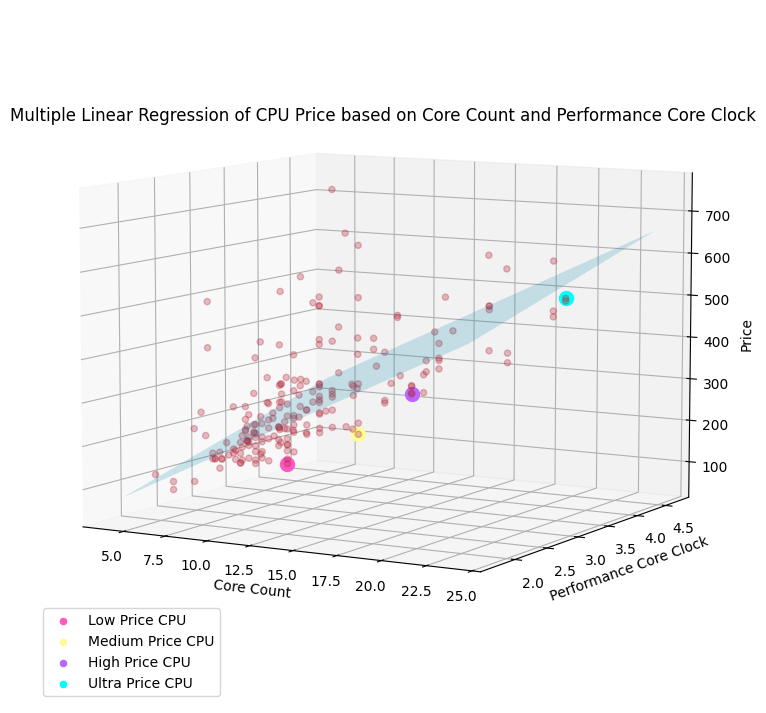

In [160]:
model = smf.ols(formula='Price ~ Core_Count + Performance_Core_Clock', data=df)
results_formula = model.fit()
#results_formula.params

x_surf, y_surf = np.meshgrid(np.linspace(df.Core_Count.min(), df.Core_Count.max(), 100),np.linspace(df.Performance_Core_Clock.min(), df.Performance_Core_Clock.max(), 100))
onlyX = pd.DataFrame({'Core_Count': x_surf.ravel(), 'Performance_Core_Clock': y_surf.ravel()})
fittedY=results_formula.predict(exog=onlyX)

fittedY=np.array(fittedY)

fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Core_Count'],df['Performance_Core_Clock'],df['Price'],c='#b42a3d', marker='o', alpha=0.3)
ax.plot_surface(x_surf,y_surf,fittedY.reshape(x_surf.shape), color='#0190ba', alpha=0.2)
ax.set_xlabel('Core Count')
ax.set_ylabel('Performance Core Clock')
ax.set_zlabel('Price')
ax.view_init( elev=8)
ax.scatter(best_low_cpu['Core_Count'],best_low_cpu['Performance_Core_Clock'],best_low_cpu['Price'],c ='#ff58c5',s=100)
ax.scatter(best_medium_cpu['Core_Count'],best_medium_cpu['Performance_Core_Clock'],best_medium_cpu['Price'],c="#fffb96",s=100)
ax.scatter(best_high_cpu['Core_Count'],best_high_cpu['Performance_Core_Clock'],best_high_cpu['Price'],c="#b967ff",s=100)
ax.scatter(best_ultra_cpu['Core_Count'],best_ultra_cpu['Performance_Core_Clock'],best_ultra_cpu['Price'],c="#00fff9",s=100)
#create a legend
ax.scatter([],[],[],c="#ff58c5",label='Low Price CPU')
ax.scatter([],[],[],c="#fffb96",label='Medium Price CPU')
ax.scatter([],[],[],c="#b967ff",label='High Price CPU')
ax.scatter([],[],[],c="#00fff9",label='Ultra Price CPU')
#put the legend to the lower left
ax.legend(loc='lower left')
#create a title
plt.title('Multiple Linear Regression of CPU Price based on Core Count and Performance Core Clock')
#move the title down
plt.title('Multiple Linear Regression of CPU Price based on Core Count and Performance Core Clock', y=.9)
plt.show()
